# Lorenz Attractor 

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/examples_odes/example_lorenz.py).This example demonstrates the famous **Lorenz attractor**, a system of ordinary differential equations that exhibits chaotic behavior. It's one of the most iconic examples in chaos theory and was discovered by Edward Lorenz in 1963 while studying atmospheric convection.

## The Lorenz System

The system consists of three coupled nonlinear ODEs:

$$\frac{dx}{dt} = \sigma(y - x)$$
$$\frac{dy}{dt} = x(\rho - z) - y$$
$$\frac{dz}{dt} = xy - \beta z$$

Where the parameters are:
- $\sigma = 10$ (Prandtl number)
- $\rho = 28$ (Rayleigh number)
- $\beta = 8/3$ (geometric factor)

## Chaotic Behavior

For these parameters, the system exhibits **sensitive dependence on initial conditions** - tiny changes in starting values lead to completely different trajectories. Despite being deterministic, the system appears random and unpredictable over long timescales.

## Building the System in PathSim

We'll construct the Lorenz system using basic blocks (integrators, amplifiers, multipliers, adders) to show PathSim's block-diagram approach to ODEs.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style for consistent, theme-friendly figures
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import Scope, Integrator, Constant, Adder, Amplifier, Multiplier
from pathsim.solvers import RKBS32

## System Parameters and Initial Conditions

In [5]:
# Lorenz parameters
sigma, rho, beta = 10, 28, 8/3

# Initial conditions
x0, y0, z0 = 1.0, 1.0, 1.0

## Block Diagram

We create blocks for each equation:

### For dx/dt = σ(y - x):
- Compute (y - x) with an adder
- Multiply by σ
- Integrate to get x

### For dy/dt = x(ρ - z) - y:
- Compute (ρ - z)
- Multiply by x
- Subtract y
- Integrate to get y

### For dz/dt = xy - βz:
- Multiply x and y
- Subtract βz
- Integrate to get z

In [8]:
# Integrators store the state variables x, y, z
itg_x = Integrator(x0)  # dx/dt = sigma * (y - x)
itg_y = Integrator(y0)  # dy/dt = x * (rho - z) - y
itg_z = Integrator(z0)  # dz/dt = x * y - beta * z

# Components for dx/dt
amp_sigma = Amplifier(sigma)
add_x = Adder("+-")  # Computes y - x

# Components for dy/dt
cns_rho = Constant(rho)
add_rho_z = Adder("+-")  # Computes rho - z
mul_x_rho_z = Multiplier()  # Computes x * (rho - z)
add_y = Adder("-+")  # Computes -y + [x * (rho - z)]

# Components for dz/dt
mul_xy = Multiplier()  # Computes x * y
amp_beta = Amplifier(beta)  # Computes beta * z
add_z = Adder("+-")  # Computes (x * y) - (beta * z)

# Scope for plotting
sco = Scope(labels=["x", "y", "z"])

# List of all blocks
blocks = [
    itg_x, itg_y, itg_z,
    amp_sigma, add_x,
    cns_rho, add_rho_z, mul_x_rho_z, add_y,
    mul_xy, amp_beta, add_z,
    sco
]

## Connections

The connections wire up the differential equations according to the Lorenz system.

In [11]:
connections = [
    # Output signals (from integrators)
    Connection(itg_x, add_x[1], mul_x_rho_z[0], mul_xy[0], sco[0]),  # x
    Connection(itg_y, add_x[0], add_y[0], mul_xy[1], sco[1]),        # y
    Connection(itg_z, add_rho_z[1], amp_beta, sco[2]),               # z

    # dx/dt path: sigma * (y - x) -> itg_x
    Connection(add_x, amp_sigma),
    Connection(amp_sigma, itg_x),

    # dy/dt path: x * (rho - z) - y -> itg_y
    Connection(cns_rho, add_rho_z[0]),
    Connection(add_rho_z, mul_x_rho_z[1]),
    Connection(mul_x_rho_z, add_y[1]),
    Connection(add_y, itg_y),

    # dz/dt path: x * y - beta * z -> itg_z
    Connection(mul_xy, add_z[0]),
    Connection(amp_beta, add_z[1]),
    Connection(add_z, itg_z)
]

## Simulation Setup


In [14]:
Sim = Simulation(
    blocks,
    connections,
    Solver=RKBS32,
    tolerance_lte_rel=1e-4,
    tolerance_lte_abs=1e-6,
    tolerance_fpi=1e-6
)

# Run the simulation
Sim.run(50)

2025-10-10 11:14:37,413 - INFO - LOGGING (log: True)
2025-10-10 11:14:37,414 - INFO - BLOCK (type: Integrator, dynamic: True, events: 0)
2025-10-10 11:14:37,414 - INFO - BLOCK (type: Integrator, dynamic: True, events: 0)
2025-10-10 11:14:37,415 - INFO - BLOCK (type: Integrator, dynamic: True, events: 0)
2025-10-10 11:14:37,415 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-10-10 11:14:37,415 - INFO - BLOCK (type: Adder, dynamic: False, events: 0)
2025-10-10 11:14:37,415 - INFO - BLOCK (type: Constant, dynamic: False, events: 0)
2025-10-10 11:14:37,415 - INFO - BLOCK (type: Adder, dynamic: False, events: 0)
2025-10-10 11:14:37,415 - INFO - BLOCK (type: Multiplier, dynamic: False, events: 0)
2025-10-10 11:14:37,416 - INFO - BLOCK (type: Adder, dynamic: False, events: 0)
2025-10-10 11:14:37,416 - INFO - BLOCK (type: Multiplier, dynamic: False, events: 0)
2025-10-10 11:14:37,416 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-10-10 11:14:37,417 - INFO - B

{'total_steps': 4671,
 'successful_steps': 4058,
 'runtime_ms': 992.0800999971107}

## Results: Time Series

First, let's look at how x, y, and z evolve over time. Notice the irregular, non-repeating patterns characteristic of chaos.

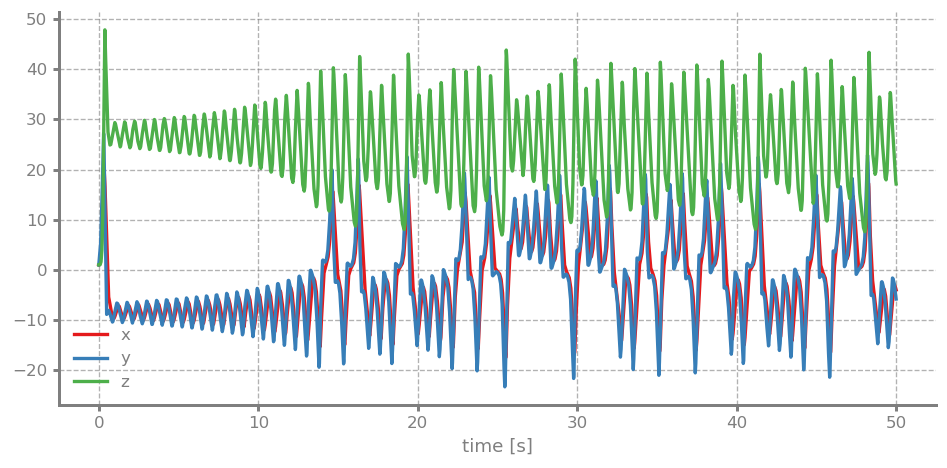

In [17]:
sco.plot()
plt.show()

## The Famous Butterfly Shape - 3D Attractor

The true beauty of the Lorenz attractor emerges in 3D phase space. The trajectory traces out a distinctive "butterfly" or "owl face" shape with two lobes. The system orbits chaotically around two unstable fixed points.

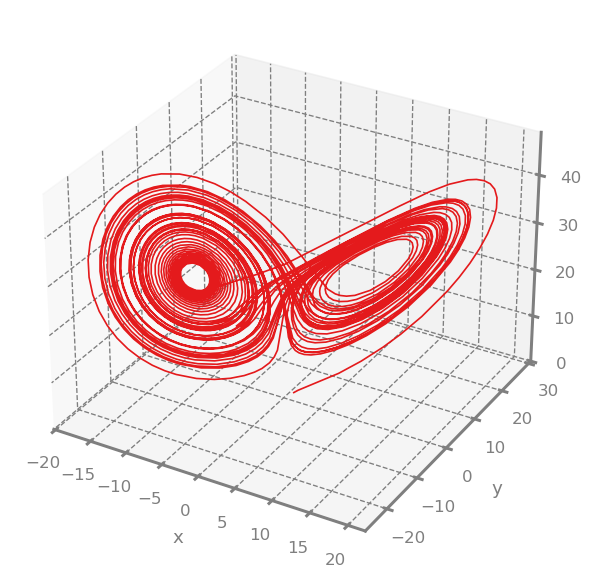

In [20]:
# Plot 3D attractor
sco.plot3D(lw=1)
plt.show()

## 2D Projections

We can also view 2D projections of the attractor to see its structure from different angles.

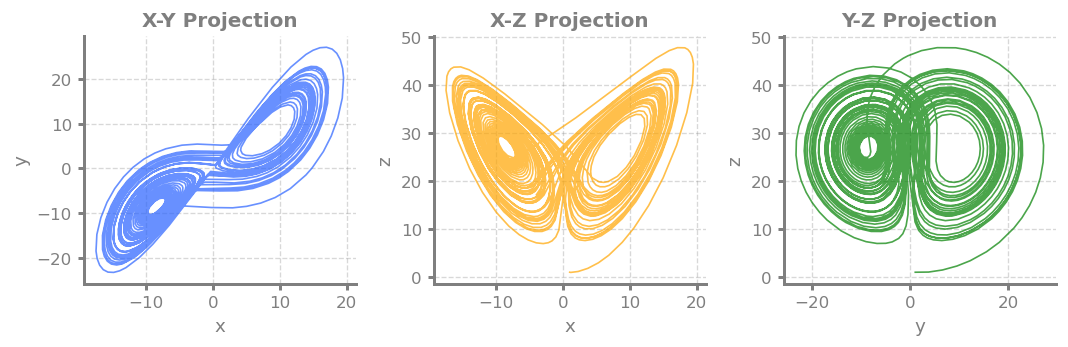

In [29]:
# Get trajectory data
time, [x, y, z] = sco.read()

# Create 2D projections
fig, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=120)

# X-Y plane
axes[0].plot(x, y, linewidth=1, alpha=0.7)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('X-Y Projection')
axes[0].grid(True, alpha=0.3)

# X-Z plane
axes[1].plot(x, z, linewidth=1, alpha=0.7, color='orange')
axes[1].set_xlabel('x')
axes[1].set_ylabel('z')
axes[1].set_title('X-Z Projection')
axes[1].grid(True, alpha=0.3)

# Y-Z plane
axes[2].plot(y, z, linewidth=1, alpha=0.7, color='green')
axes[2].set_xlabel('y')
axes[2].set_ylabel('z')
axes[2].set_title('Y-Z Projection')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()